In [2]:
import os
import shutil
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

path_MG = '/content/drive/MyDrive/00gerem00/DL-AI-Project'
path_LM = '/content/drive/MyDrive/lorenzomeroni02/DL-AI-Project'

if os.path.exists(path_MG):
    working_dir = path_MG
    print(f"Working in MG folder: {working_dir}")
elif os.path.exists(path_LM):
    working_dir = path_LM
    print(f"Working in LM folder: {working_dir}")
else:
    print("Error: Project folder not found in Drive. Check the paths.")
    working_dir = None

if working_dir:
    os.chdir(working_dir)
    zip_filename = 'leather-defect-classification.zip'
    fast_local_dir = '/content/fast_dataset'

    if os.path.exists(zip_filename):
        print(f"Great! {zip_filename} found on Drive.")

        if not os.path.exists(fast_local_dir):
            print("Creating fast local directory and extracting data...")
            os.makedirs(fast_local_dir, exist_ok=True)
            !unzip -q {zip_filename} -d {fast_local_dir}
        else:
            print("Dataset already exists in this Colab Session!")
    else:
        print(f"Error: {zip_filename} not found. Please run the Data Loading notebook first.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working in LM folder: /content/drive/MyDrive/lorenzomeroni02/DL-AI-Project
Great! leather-defect-classification.zip found on Drive.
Dataset already exists in this Colab Session!


In [3]:
from torchvision.datasets import ImageFolder

base_dir = '/content/fast_dataset'

content = os.listdir(base_dir)
subfolders = [f for f in content if os.path.isdir(os.path.join(base_dir, f))][0]
data_dir = os.path.join(base_dir, subfolders)

print(f"Data path identified: {data_dir}")

dataset = ImageFolder(
    root = data_dir,
    transform = None)

print(f"Total number of images: {len(dataset)}")
print(f"Classes found: {dataset.classes}")
print(f"Index mapping: {dataset.class_to_idx}")

Data path identified: /content/fast_dataset/Leather Defect Classification
Total number of images: 3600
Classes found: ['Folding marks', 'Grain off', 'Growth marks', 'loose grains', 'non defective', 'pinhole']
Index mapping: {'Folding marks': 0, 'Grain off': 1, 'Growth marks': 2, 'loose grains': 3, 'non defective': 4, 'pinhole': 5}


In [6]:
from PIL import Image

dataset.samples = [s for s in dataset.samples if Image.open(s[0]).size == (227, 227)]
dataset.imgs = dataset.samples
dataset.targets = [s[1] for s in dataset.samples]
print(f"{len(dataset)} images")

3598 images


# **2. Data Preprocessing & DataLoader**

First of all, to prepare the dataset for training we decide to split it in train, validation and test set. We opted for a standard 70, 15, 15 split ratio. Specifically, 70% of the data is allocated to the training set. The remaining 30% is divided equally between the validation and test sets. The validation set is actively used at the end of each epoch to monitor the model's generalization capabilities and prevent overfitting, while the test set is kept strictly isolated until the very end. This ensures an completely unbiased final evaluation of the model's accuracy.

In [7]:
import torch
from torch.utils.data import random_split

train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Completed split: {len(train_set)} training set, {len(val_set)} validation set, {len(test_set)} test set")

Completed split: 2518 training set, 540 validation set, 540 test set


Then we The `TransformSubset` Wrapper is used to apply preprocessing steps after the random dataset splitting. This ensures us to have each set applied the desired transormation without altering the underlying dataset structure.

In [8]:
from torchvision import transforms
from torch.utils.data import Dataset

class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

The goal of the training pipeline `train_transform` is **Data Augmentation** to artificially increase the diversity of the training set without collecting new data. In our leather defect classification task, it serves two main purposes:

1. **Increasing Variability:** It helps the model capture defects from multiple angles and under various lighting conditions, compensating for the fact that the images in our training set (2518) might not cover every real world scenario.
2. **Regularization and Preventing Overfitting:** By presenting a slightly different version of the same image in each epoch, we prevent the network from "memorizing" specific pixel patterns (noise). Instead, we force it to focus on robust, invariant structural and chromatic features of the defects (*folding marks, pinholes, etc.*).

These are the operations we applied:
* `transforms.Resize((230, 230))`: Starting from original $227 \times 227$ images, we upscale them to $230 \times 230$. Since it is impossible to create new data out of thin air, the system uses **Bilinear Interpolation**. The algorithm analyzes the original pixel grid and, as it "stretches" the image, fills the resulting gaps by calculating a weighted average of adjacent pixels.

* `transforms.RandomCrop((224, 224))`: We randomly cut out a $224 \times 224$ square from the $230 \times 230$ image. This teaches the model spatial invariance. Tt learns to recognize a defect whether it is perfectly in the center or slightly off to the edge.

* `transforms.RandomHorizontalFlip(p=0.5)`: There is a 50% probability the image will be flipped like a mirror. A scratch or a pinhole is still a defect regardless of whether it points left or right.

* `transforms.RandomRotation(15)`: We rotate the image by a random angle between -15 and +15 degrees. This simulates variations in how the camera or the leather might have been positioned on the factory line.

* `transforms.ColorJitter(brightness=0.15, contrast=0.12)`: This randomly alters the lighting. It prevents the model from relying on a specific factory lighting condition, making it robust against brighter or darker environments.
* `transforms.ToTensor()`: T It does not merely change the data type. It reshapes the raw image from a spatial format (Height $\times$ Width $\times$ Channels) with pixel intensities in the [0, 255] range, into a PyTorch compatible Tensor (Channels $\times$ Height $\times$ Width), scaling the values down to a [0.0, 1.0] float range for numerical stability.

* `transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])`: It takes the [0.0, 1.0] tensor and applies normalization using a mean and standard deviation of $0.5$ across all three RGB channels.: $z = \frac{x_{c} - 0.5}{0.5}$ . This operation maps the data to an exact [-1.0, 1.0] range. The zero-centered distribution ensures numerical stability and faster gradient convergence during backpropagation.

Moreover, we apply training `mean` and `std` to both validation and test sets, since they must be normalized using the exact empirical mean and standard deviation computed exclusively from the training set. This ensures **Feature Space Consistency**: the neural network optimizes its weights based on the specific mathematical distribution of the training data; applying different normalization parameters to the test data would shift this distribution and invalidate the model's learned weights.


In [9]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((230, 230)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.12),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_final = TransformSubset(train_set, transform=train_transform)
val_final = TransformSubset(val_set, transform=val_test_transform)
test_final = TransformSubset(test_set, transform=val_test_transform)

`DataLoaders` are created, which are essential tools for optimizing the data flow to the neural network. These components manage mini-batching by grouping images into blocks of 32 samples, obtaining gradient stability and computational efficiency.

The shuffle feature is enabled exclusively for the training set, reordering the images at each epoch to prevent the model from memorizing sequences and forcing it to recognize the actual visual patterns of leather defects. Conversely, validation and test data are loaded deterministically and sequentially, ensuring a rigorous evaluation and the accurate generation of the final confusion matrix through data unaltered by stochastic processes.

In [10]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(
    train_final,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_final,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_final,
    batch_size=batch_size,
    shuffle=False
)

To verify the effectiveness of our preprocessing pipeline, we visualized a selection of images before and after applying data augmentation. By comparing the raw leather surfaces with their transformed counterparts, we can observe the impact of the rotation, scaling, and color jittering operations.

This step serves as a visual sanity check to ensure that the transformations introduce sufficient variability to prevent overfitting while preserving the distinctive features of each defect class.

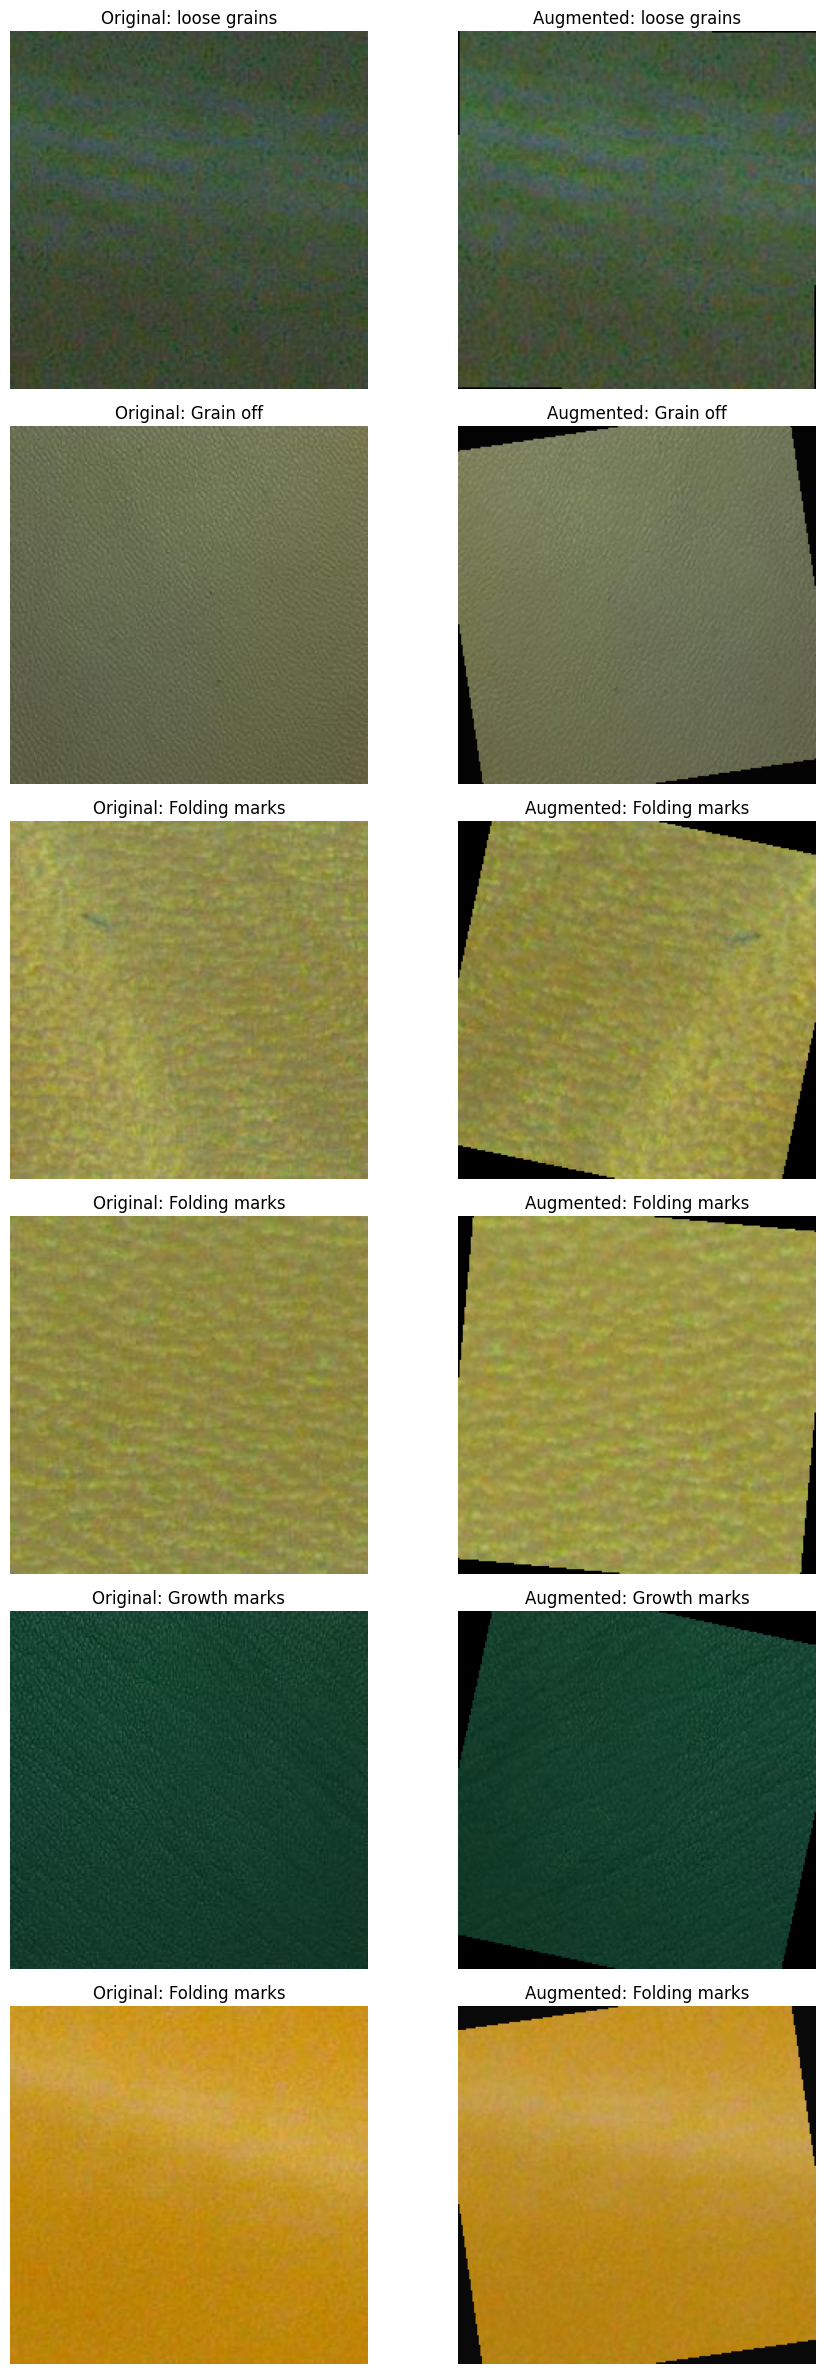

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

num_images = 6
random_indices = random.sample(range(len(train_final)), num_images)

fig, axes = plt.subplots(num_images, 2, figsize=(10, 4 * num_images))
fig.suptitle("", fontsize=16)

for i, idx in enumerate(random_indices):
    orig_img, label_idx = train_final.subset[idx]
    aug_tensor, _ = train_final[idx]

    aug_img = aug_tensor / 2 + 0.5
    aug_np = aug_img.numpy()
    aug_np = np.transpose(aug_np, (1, 2, 0))

    label_name = dataset.classes[label_idx]

    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original: {label_name}", fontsize=12)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(aug_np)
    axes[i, 1].set_title(f"Augmented: {label_name}", fontsize=12)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# **Model A: Custom ResNet-18**

NB: nella CustomResnNet18 abbiamo tolto il Max-Pooling

# **Model implementation**

We implement a custom version of **ResNet-18**, specifically designed for our leather defect classification task. The model follows the residual learning framework introduced by He et al. in *Deep Residual Learning for Image Recognition* , but it is implemented from scratch in PyTorch to maintain full architectural control and adapt it to the specific characteristics of our dataset.

As originally proposed, ResNet reformulates the learning objective so that stacked layers approximate a **residual function** $( F(x) := H(x) - x )$, allowing the network to learn mappings of the form $( F(x) + x )$ through identity shortcut connections . These shortcuts facilitate gradient propagation and address the degradation problem observed in very deep plain networks.

Building upon this principle, our implementation preserves the core residual structure while introducing task-specific adaptations aimed at improving performance on fine-grained leather surface defects.


## Residual Block (BasicBlock)

Each residual block consists of:

* two 3×3 convolutional layers;
* Batch Normalization after each convolution;
* ReLU activation;
* an identity shortcut connection.

If the spatial resolution or the number of channels changes (i.e., when `stride ≠ 1` or `in_channels ≠ out_channels`), the shortcut path is adjusted using:

* a 1×1 convolution,
* followed by Batch Normalization.

The residual mapping can be expressed as: $[F(x) + x]$,  where:

* (F(x)) represents the stacked convolutional transformations,
* (x) is the identity shortcut.

This design ensures that the block can learn either a residual function or, if needed, preserve the identity mapping.

## Network Architecture

The overall architecture follows the classical ResNet-18 configuration:

### Initial Convolutional Layer

* 7×7 convolution
* 64 output channels
* stride = 2
* padding = 3
* followed by BatchNorm and ReLU

Unlike the original ImageNet ResNet-18, **the initial max-pooling layer is removed**.
This choice preserves more spatial information, which is important for detecting fine-grained texture defects in leather surfaces.

### Residual Layers

The network is composed of four residual stages:

* **Layer 1:** 2 BasicBlocks, 64 channels
* **Layer 2:** 2 BasicBlocks, 128 channels (stride=2 for downsampling)
* **Layer 3:** 2 BasicBlocks, 256 channels (stride=2)
* **Layer 4:** 2 BasicBlocks, 512 channels (stride=2)

Downsampling occurs at the beginning of layers 2, 3, and 4 via stride=2 in the first block of each layer.

This progressive reduction in spatial dimensions combined with an increase in channel depth allows the network to extract increasingly abstract features.

## Global Feature Aggregation

After the final residual stage:

* An **Adaptive Average Pooling layer** reduces the spatial dimensions to 1×1, independently of the input size.

This guarantees architectural flexibility: regardless of intermediate feature map sizes, the output becomes a 512-dimensional feature vector.

## Classification Head

The final classifier consists of:

* a fully connected layer: $\text{Linear}(512 \rightarrow 6)$ where 6 corresponds to the number of defect classes.

Unlike deeper ResNet variants (e.g., ResNet-50/101/152), which use bottleneck blocks, our architecture employs the basic two-layer residual block, consistent with canonical ResNet-18.

## Design Choices and Rationale

The main architectural choices are:

* Residual learning to stabilize deep training.
* Removal of the initial max-pooling layer to retain spatial detail.
* Progressive channel expansion (64 → 128 → 256 → 512).
* Adaptive average pooling to simplify dimensional handling.
* Single fully connected classification layer for direct multiclass prediction.

This implementation provides a strong and interpretable baseline model for multiclass leather defect classification, while maintaining architectural transparency and full control over training dynamics.

In [11]:
import torch
import torch.nn as nn


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out


class CustomResNet18(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)


        # --- I 4 STRATI DI BLOCCHI RESIDUI ---
        self.layer1 = self._make_layer(64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(512, num_blocks=2, stride=2)

        # --- CLASSIFICATORE FINALE ---
        # L'AdaptiveAvgPool è magico: non gli importa se in ingresso arrivano
        # tensori 7x7 o 14x14, li schiaccerà sempre e comunque a 1x1.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride=s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# **Setting the GPU**

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in uso: {device}")

model = CustomResNet18(num_classes=6)

model = model.to(device)

Device in uso: cuda


### **NB: Modello da Scartare**

In [ ]:
import torch.optim as optim
import time
import torch.nn as nn
import torch

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==========================================
# NOVITÀ: IL LEARNING RATE SCHEDULER
# ==========================================
# mode='min': lo scheduler osserva se la metrica (la loss) scende.
# factor=0.1: quando interviene, moltiplica il LR per 0.1 (es. da 0.001 passa a 0.0001).
# patience=3: aspetta 3 epoche in cui la validation loss non migliora prima di agire.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# 2. Impostazioni del ciclo di addestramento
num_epochs = 40
# Ho aggiunto 'lr' alla history per poterlo graficare in seguito!
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

print("Inizio addestramento con Learning Rate dinamico...")

for epoch in range(num_epochs):
    start_time = time.time()

    # Leggiamo il Learning Rate attuale per tenerne traccia
    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)

    # --- FASE DI ADDESTRAMENTO ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = correct_train / total_train

    # --- FASE DI VALIDAZIONE ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / total_val
    val_acc = correct_val / total_val

    # Salvataggio metriche
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # ==========================================
    # NOVITÀ: AGGIORNIAMO LO SCHEDULER
    # ==========================================
    # Diciamo allo scheduler di guardare la val_loss. Se non scende per 3 epoche, taglia il LR!
    scheduler.step(val_loss)

    epoch_time = time.time() - start_time

    # Stampa dei risultati, ora includiamo anche il Learning Rate per monitorarlo
    print(f"Epoca [{epoch+1:2d}/{num_epochs}] - Tempo: {epoch_time:.0f}s - LR: {current_lr:.6f}")
    print(f"  Train -> Loss: {train_loss:.4f} | Accuracy: {train_acc*100:.2f}%")
    print(f"  Val   -> Loss: {val_loss:.4f} | Accuracy: {val_acc*100:.2f}%")
    print("-" * 30)

print("Addestramento terminato.")

Inizio addestramento con Learning Rate dinamico...
Epoca [ 1/40] - Tempo: 37s - LR: 0.001000
  Train -> Loss: 1.3704 | Accuracy: 45.47%
  Val   -> Loss: 1.6475 | Accuracy: 37.04%
------------------------------
Epoca [ 2/40] - Tempo: 35s - LR: 0.001000
  Train -> Loss: 1.1158 | Accuracy: 50.64%
  Val   -> Loss: 1.1694 | Accuracy: 51.48%
------------------------------
Epoca [ 3/40] - Tempo: 36s - LR: 0.001000
  Train -> Loss: 1.0486 | Accuracy: 54.41%
  Val   -> Loss: 1.0930 | Accuracy: 49.26%
------------------------------
Epoca [ 4/40] - Tempo: 36s - LR: 0.001000
  Train -> Loss: 0.9570 | Accuracy: 57.86%
  Val   -> Loss: 1.2493 | Accuracy: 50.00%
------------------------------
Epoca [ 5/40] - Tempo: 37s - LR: 0.001000
  Train -> Loss: 1.0529 | Accuracy: 55.32%
  Val   -> Loss: 1.0794 | Accuracy: 54.44%
------------------------------
Epoca [ 6/40] - Tempo: 37s - LR: 0.001000
  Train -> Loss: 0.9211 | Accuracy: 61.40%
  Val   -> Loss: 0.7354 | Accuracy: 63.70%
--------------------------

# **Plots**

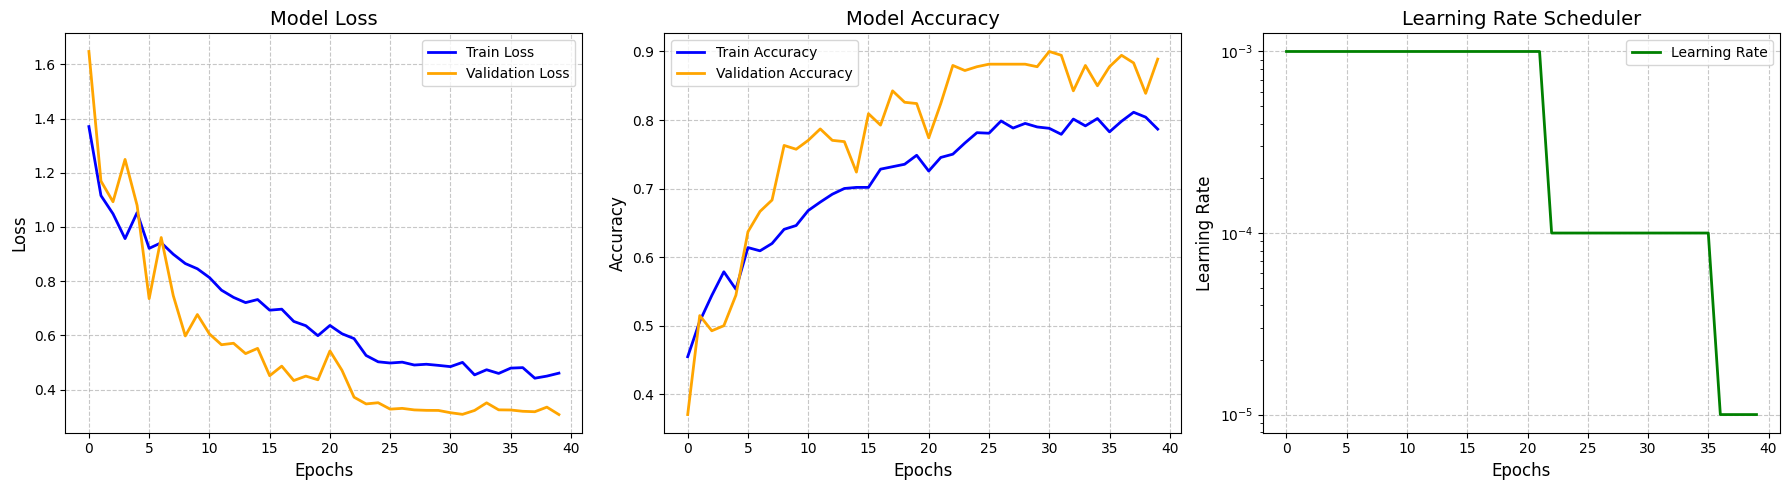

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Creiamo una figura con 3 grafici affiancati
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# --- Grafico 1: LOSS ---
ax1.plot(history['train_loss'], label='Train Loss', color='blue', linewidth=2)
ax1.plot(history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
ax1.set_title('Model Loss', fontsize=14)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# --- Grafico 2: ACCURACY ---
ax2.plot(history['train_acc'], label='Train Accuracy', color='blue', linewidth=2)
ax2.plot(history['val_acc'], label='Validation Accuracy', color='orange', linewidth=2)
ax2.set_title('Model Accuracy', fontsize=14)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# --- Grafico 3: LEARNING RATE ---
ax3.plot(history['lr'], label='Learning Rate', color='green', linewidth=2)
ax3.set_title('Learning Rate Scheduler', fontsize=14)
ax3.set_xlabel('Epochs', fontsize=12)
ax3.set_ylabel('Learning Rate', fontsize=12)
# Usiamo una scala logaritmica per l'asse Y per visualizzare bene i salti
ax3.set_yscale('log')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# --- SALVATAGGIO FINALE DEL CHECKPOINT ---
print("Addestramento terminato. Salvataggio del checkpoint su Drive...")

checkpoint_path = '/content/drive/MyDrive/00gerem00/DL-AI-Project/resnet18_leather_checkpoint.pth'

torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_loss,
    'history': history
}, checkpoint_path)

Addestramento terminato. Salvataggio del checkpoint su Drive...


# **Model training**

To optimize the training process of our Custom ResNet-18, we performed a **grid search over different initial learning rates** in order to identify the configuration yielding the best validation performance. Specifically, we evaluated four candidate values: $[{10^{-3}; 5 \times 10^{-4}; 10^{-4}; 10^{-5}}]$

For each learning rate, the model was trained for a maximum of 80 epochs using the **Adam optimizer** and **Cross-Entropy Loss**, which is appropriate for our six-class classification problem.

[SI PUò FARE PIù APPROFONDITO ADAM OPTIMIZER]

**Adam optimizer** is particularly appropriate for our setting because it adapts the learning rate individually for each parameter, which is beneficial in deep convolutional networks where early layers extract low-level texture features while deeper layers learn more abstract representations. Given the relatively small size of our dataset (3600 images) and the need to test multiple learning rates through grid search, Adam provides fast and stable convergence, allowing the model to reach good performance without requiring extensive manual tuning. Moreover, since some defect categories are visually similar and differ only in subtle texture patterns, gradient updates may vary across batches; Adam’s adaptive mechanism helps maintain smooth and robust optimization under these conditions.

## Loss function

In our model, we adopt **Cross Entropy Loss** as the training objective, as our task consists of a six-class classification problem where each image belongs to exactly one defect category. Since the classes are mutually exclusive, the objective is to maximize the predicted probability of the correct class while minimizing the probabilities assigned to the others.

Given the raw logits $( z_i )$ produced by the final linear layer $(512 → 6)$, Cross Entropy internally applies the Softmax function:

$[
p_i = \frac{e^{z_i}}{\sum_{j=1}^{6} e^{z_j}}
]$

where $( p_i )$ represents the predicted probability for class $( i )$.
The loss for a single sample is then defined as:

$[
\ {L} = - \sum_{i=1}^{6} y_i \log(p_i)
]$

where $( y_i )$ is the one-hot encoded ground truth label.

This formulation is particularly appropriate for our leather defect classification problem for the following reasons:

* It directly optimizes **class probabilities**, ensuring that the model learns to assign high confidence to the correct defect category.
* It strongly penalizes confident misclassifications, since if the model assigns high probability to an incorrect class, the term $( \log(p_i) )$ becomes very negative, leading to a large loss value.
* It encourages sharper decision boundaries, which is crucial in our dataset where certain defect classes (e.g., folding marks vs. loose grains) differ only by subtle texture variations.

Moreover, minimizing Cross Entropy is equivalent to minimizing the Kullback–Leibler divergence between the true distribution and the predicted distribution: $[\ {L} = D_{KL}(y ,|, p)]$ which provides a probabilistic interpretation of the optimization process.

Since our network outputs raw logits and does not explicitly include a Softmax layer in the forward pass, using `nn.CrossEntropyLoss()` ensures both numerical stability and correct probabilistic modeling.

Together, Adam and Cross Entropy form an efficient and coherent optimization framework tailored to our residual network and to the specific characteristics of our six-class leather defect dataset.

### Learning rate scheduling

To further improve training stability and generalization performance, we integrated a **ReduceLROnPlateau learning rate scheduler** into our optimization pipeline. This scheduler monitors the validation loss and automatically reduces the learning rate when performance stagnates for a predefined number of epochs (patience = 3). Specifically, when no improvement in validation loss is observed, the learning rate is multiplied by a factor of 0.1: $[\eta_{new} = 0.1 \cdot \eta_{current}]$ where $( \eta )$ denotes the learning rate.

This mechanism is particularly suitable for our setting for several reasons, in fact during the early stages of training, a relatively higher learning rate allows the optimizer to perform larger parameter updates: $[\theta_{t+1} = \theta_t - \eta \nabla_\theta \ {L} ]$ which helps the model rapidly move toward a good region of the parameter space. However, as training progresses and the model approaches a local minimum, large updates may cause oscillations or prevent fine convergence.

When the validation loss plateaus, it typically indicates that the model has reached a region where smaller gradient steps are needed to refine the solution. Reducing the learning rate allows:

* more precise parameter updates,
* smoother convergence toward a minimum,
* improved generalization by avoiding overshooting.

In our leather defect classification task, this adaptive adjustment is particularly important because:

* the dataset is relatively small (3600 images), increasing the risk of overfitting,
* some classes are visually similar, requiring fine-grained feature adjustments in later training stages,
* residual networks benefit from stable late-phase optimization to fully exploit deeper feature representations.

By dynamically lowering the learning rate based on validation performance rather than following a fixed schedule, the training process becomes more responsive to the actual optimization dynamics of our model. This results in a more efficient and controlled convergence behavior, especially during the final epochs of training.

### Early stopping

To prevent overfitting and unnecessary computation, we implemented an **Early Stopping mechanism** based on validation loss. If no improvement was observed for 10 consecutive epochs (patience = 10), training was interrupted. This ensures that the selected model corresponds to the best generalization performance rather than the final training epoch.

### Monitoring and logging

For each configuration, we recorded:

* Training loss
* Training accuracy
* Validation loss
* Validation accuracy
* Learning rate evolution
* Epoch duration

This comprehensive monitoring allowed us to analyze both optimization dynamics and generalization behavior across different learning rates.

### Model selection criterion

The best model was selected based on the **lowest validation loss achieved across all grid search runs**, rather than on final training accuracy.

Selecting the configuration with the minimum validation loss ensures that the model not only classifies correctly but also produces well-calibrated probability distributions. In fine-grained texture classification tasks such as ours, accuracy alone may not fully capture the quality of the learned decision boundaries. A lower validation loss indicates that the model is confidently correct while avoiding overconfident misclassifications, which is crucial when distinguishing visually similar defects.

For each initial learning rate tested in the grid search $({10^{-3}; 5 \times 10^{-4}; 10^{-4}; 10^{-5}})$, we stored:

* the best validation loss reached during training,
* the corresponding validation accuracy,
* the complete training history (loss, accuracy, learning rate evolution, and epoch duration).

This detailed logging allows us to analyze not only final performance but also optimization dynamics, such as convergence speed and stability across different learning rates.

The global best model was defined as: $[\theta^* = \arg\min_{\theta \in {\text{all runs}}} \ {L}_{val}(\theta)]$ and its weights were saved for final evaluation. This approach ensures that the selected model represents the configuration with the strongest generalization capability, rather than the one that simply trained the longest or achieved the highest training accuracy.

In the context of our leather defect classification problem, this systematic and validation-driven model selection procedure guarantees:

* fairness, since all learning rates are evaluated under identical training conditions,
* robustness, by preventing the selection of overfitted configurations,
* reproducibility, as all metrics and training histories are stored in structured JSON files.

Overall, the grid search combined with validation-based selection provides a controlled and transparent methodology for identifying the optimal learning rate for our Custom ResNet-18 architecture.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
import os
import json

In [ ]:
REPO_PATH = '/content/drive/MyDrive/00gerem00/DL-AI-Project/'
SAVE_DIR = os.path.join(REPO_PATH, 'models_best')
os.makedirs(SAVE_DIR, exist_ok=True)

lr_values = [1e-3, 5e-4, 1e-4, 1e-5]

num_epochs = 80
patience_es = 10
patience_sched = 3

global_best_loss = float("inf")
global_best_lr = None
global_best_model_state = None

results_summary = {}
full_histories = {}

print(f"Save directory: {SAVE_DIR}")
print("STARTING GRID SEARCH WITH FULL MONITORING (LOSS, ACCURACY, LR, TIME)")

for initial_lr in lr_values:
    print("\n" + "="*70)
    print(f"TESTING INITIAL LEARNING RATE: {initial_lr}")
    print("="*70)

    model = CustomResNet18(num_classes=6).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience_sched)

    counter_es = 0
    best_val_loss_current = float("inf")

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr_evolution': [], 'epoch_duration': []
    }

    for epoch in range(num_epochs):
        start_time = time.time()

        # Track current Learning Rate before the step
        current_lr = optimizer.param_groups[0]['lr']
        history['lr_evolution'].append(current_lr)

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / total_train
        train_acc = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / total_val
        val_acc = correct_val / total_val

        scheduler.step(val_loss)

        duration = time.time() - start_time
        history['epoch_duration'].append(duration)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1:2d}/{num_epochs}] - Time: {duration:.0f}s - LR: {current_lr:.6f}")
        print(f"  Train -> Loss: {train_loss:.4f} | Accuracy: {train_acc*100:.2f}%")
        print(f"  Val   -> Loss: {val_loss:.4f} | Accuracy: {val_acc*100:.2f}%")
        print("-" * 30)

        if val_loss < best_val_loss_current:
            best_val_loss_current = val_loss
            counter_es = 0
            if val_loss < global_best_loss:
                global_best_loss = val_loss
                global_best_lr = initial_lr
                global_best_model_state = copy.deepcopy(model.state_dict())
                print(f"   *** NEW GLOBAL RECORD! Best Val Loss: {global_best_loss:.4f} ***")
        else:
            counter_es += 1
            if counter_es >= patience_es:
                print(f"Early Stopping triggered at epoch {epoch+1}.")
                break

    results_summary[f"Initial_LR_{initial_lr}"] = {
        'best_val_loss': best_val_loss_current,
        'final_accuracy': val_acc
    }
    full_histories[f"Initial_LR_{initial_lr}"] = history


best_model_path = os.path.join(SAVE_DIR, "RESNET18_GLOBAL_BEST.pth")
torch.save(global_best_model_state, best_model_path)

summary_json_path = os.path.join(SAVE_DIR, "grid_search_summary.json")
with open(summary_json_path, "w") as f:
    json.dump(results_summary, f, indent=4)

full_logs_json_path = os.path.join(SAVE_DIR, "full_training_logs.json")
with open(full_logs_json_path, "w") as f:
    json.dump(full_histories, f, indent=4)

print("\nGRID SEARCH FINISHED")
print(f"Winning Initial LR: {global_best_lr}")
print(f"Global Best Loss: {global_best_loss:.4f}")
print(f"All files saved in: {SAVE_DIR}")

Save directory: /content/drive/MyDrive/00gerem00/DL-AI-Project/models_best
STARTING GRID SEARCH WITH FULL MONITORING (LOSS, ACCURACY, LR, TIME)

TESTING INITIAL LEARNING RATE: 0.001
Epoch [ 1/80] - Time: 40s - LR: 0.001000
  Train -> Loss: 1.3584 | Accuracy: 44.80%
  Val   -> Loss: 1.0623 | Accuracy: 59.44%
------------------------------
   *** NEW GLOBAL RECORD! Best Val Loss: 1.0623 ***
Epoch [ 2/80] - Time: 39s - LR: 0.001000
  Train -> Loss: 1.1025 | Accuracy: 52.58%
  Val   -> Loss: 0.8413 | Accuracy: 65.00%
------------------------------
   *** NEW GLOBAL RECORD! Best Val Loss: 0.8413 ***
Epoch [ 3/80] - Time: 39s - LR: 0.001000
  Train -> Loss: 1.1090 | Accuracy: 52.50%
  Val   -> Loss: 0.9301 | Accuracy: 59.44%
------------------------------
Epoch [ 4/80] - Time: 39s - LR: 0.001000
  Train -> Loss: 1.0277 | Accuracy: 54.01%
  Val   -> Loss: 0.8358 | Accuracy: 63.52%
------------------------------
   *** NEW GLOBAL RECORD! Best Val Loss: 0.8358 ***
Epoch [ 5/80] - Time: 39s - LR

# **Training results overview and best model**

Thanks to the following lines of code we can reload all the weights saved according to the best find in GRID SEARCH

In [ ]:
base_path = '/content/drive/MyDrive/00gerem00/DL-AI-Project/models_best/'

with open(base_path + 'full_training_logs.json', 'r') as f:
    full_histories = json.load(f)

with open(base_path + 'grid_search_summary.json', 'r') as f:
    summary = json.load(f)

best_lr_key = "Initial_LR_0.0001"
history = full_histories[best_lr_key]

In [ ]:
model = CustomResNet18(num_classes=6)

model.load_state_dict(torch.load(base_path + 'RESNET18_GLOBAL_BEST.pth'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()


CustomResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), s

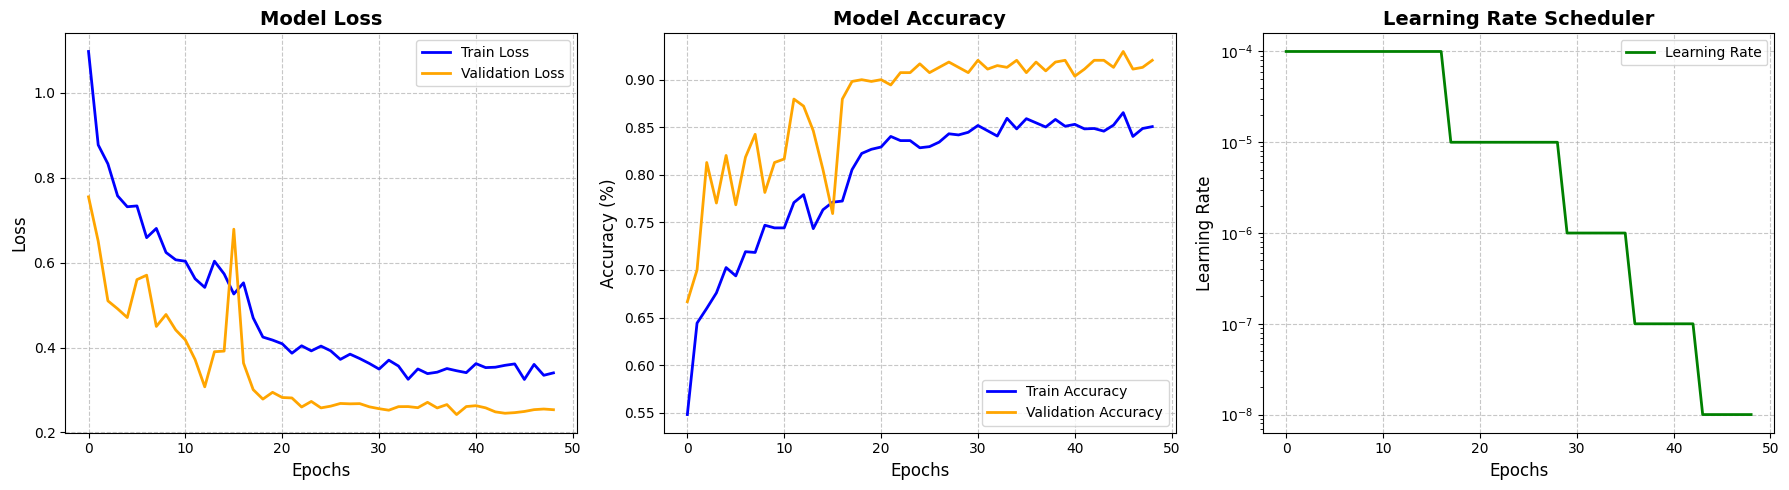

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

best_lr_key = "Initial_LR_0.0001"
history = full_histories[best_lr_key]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.plot(history['train_loss'], label='Train Loss', color='blue', linewidth=2)
ax1.plot(history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

ax1_epochs = range(len(history['train_acc']))
ax2.plot(history['train_acc'], label='Train Accuracy', color='blue', linewidth=2)
ax2.plot(history['val_acc'], label='Validation Accuracy', color='orange', linewidth=2)
ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

ax3.plot(history['lr_evolution'], label='Learning Rate', color='green', linewidth=2)
ax3.set_title('Learning Rate Scheduler', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epochs', fontsize=12)
ax3.set_ylabel('Learning Rate', fontsize=12)
ax3.set_yscale('log')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('final_report_performance_en.png', dpi=300)
plt.show()

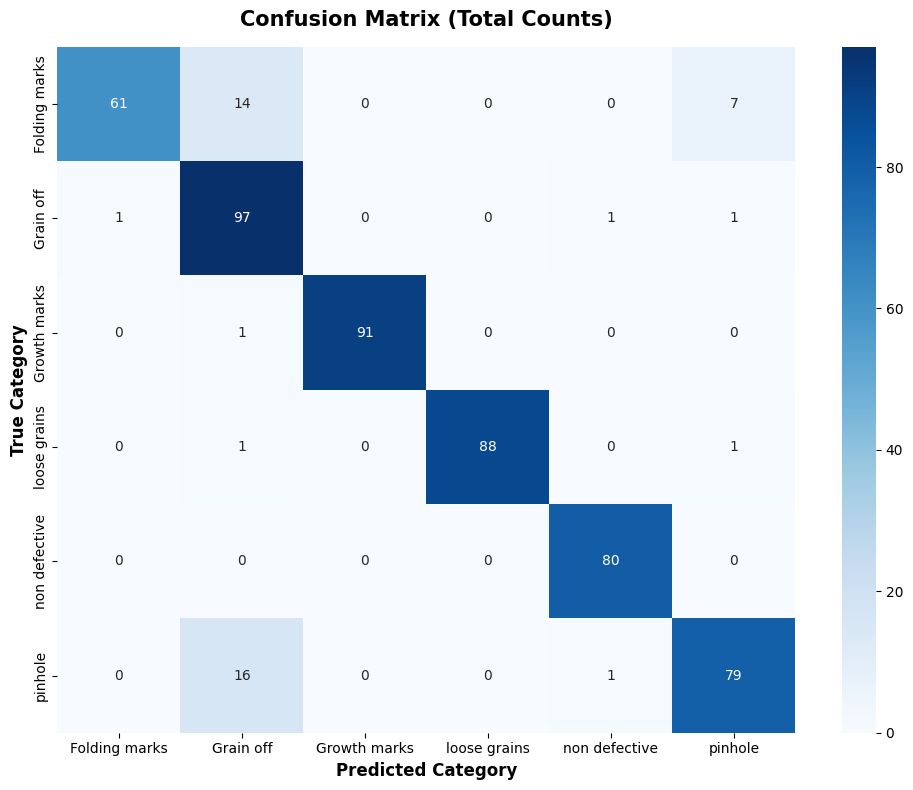

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = ['Folding marks', 'Grain off', 'Growth marks', 'loose grains', 'non defective', 'pinhole']

def confusionmat(y_true, y_pred, classes):

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)

    plt.title('Confusion Matrix (Total Counts)', fontsize=15, fontweight='bold', pad=15)
    plt.ylabel('True Category', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Category', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

confusionmat(all_labels, all_preds, class_names)

In [ ]:
print("\n" + "="*65)
print("            CLASSIFICATION PERFORMANCE")
print("="*65)
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)


            DETAILED CLASSIFICATION PERFORMANCE
               precision    recall  f1-score   support

Folding marks       0.98      0.74      0.85        82
    Grain off       0.75      0.97      0.85       100
 Growth marks       1.00      0.99      0.99        92
 loose grains       1.00      0.98      0.99        90
non defective       0.98      1.00      0.99        80
      pinhole       0.90      0.82      0.86        96

     accuracy                           0.92       540
    macro avg       0.93      0.92      0.92       540
 weighted avg       0.93      0.92      0.92       540



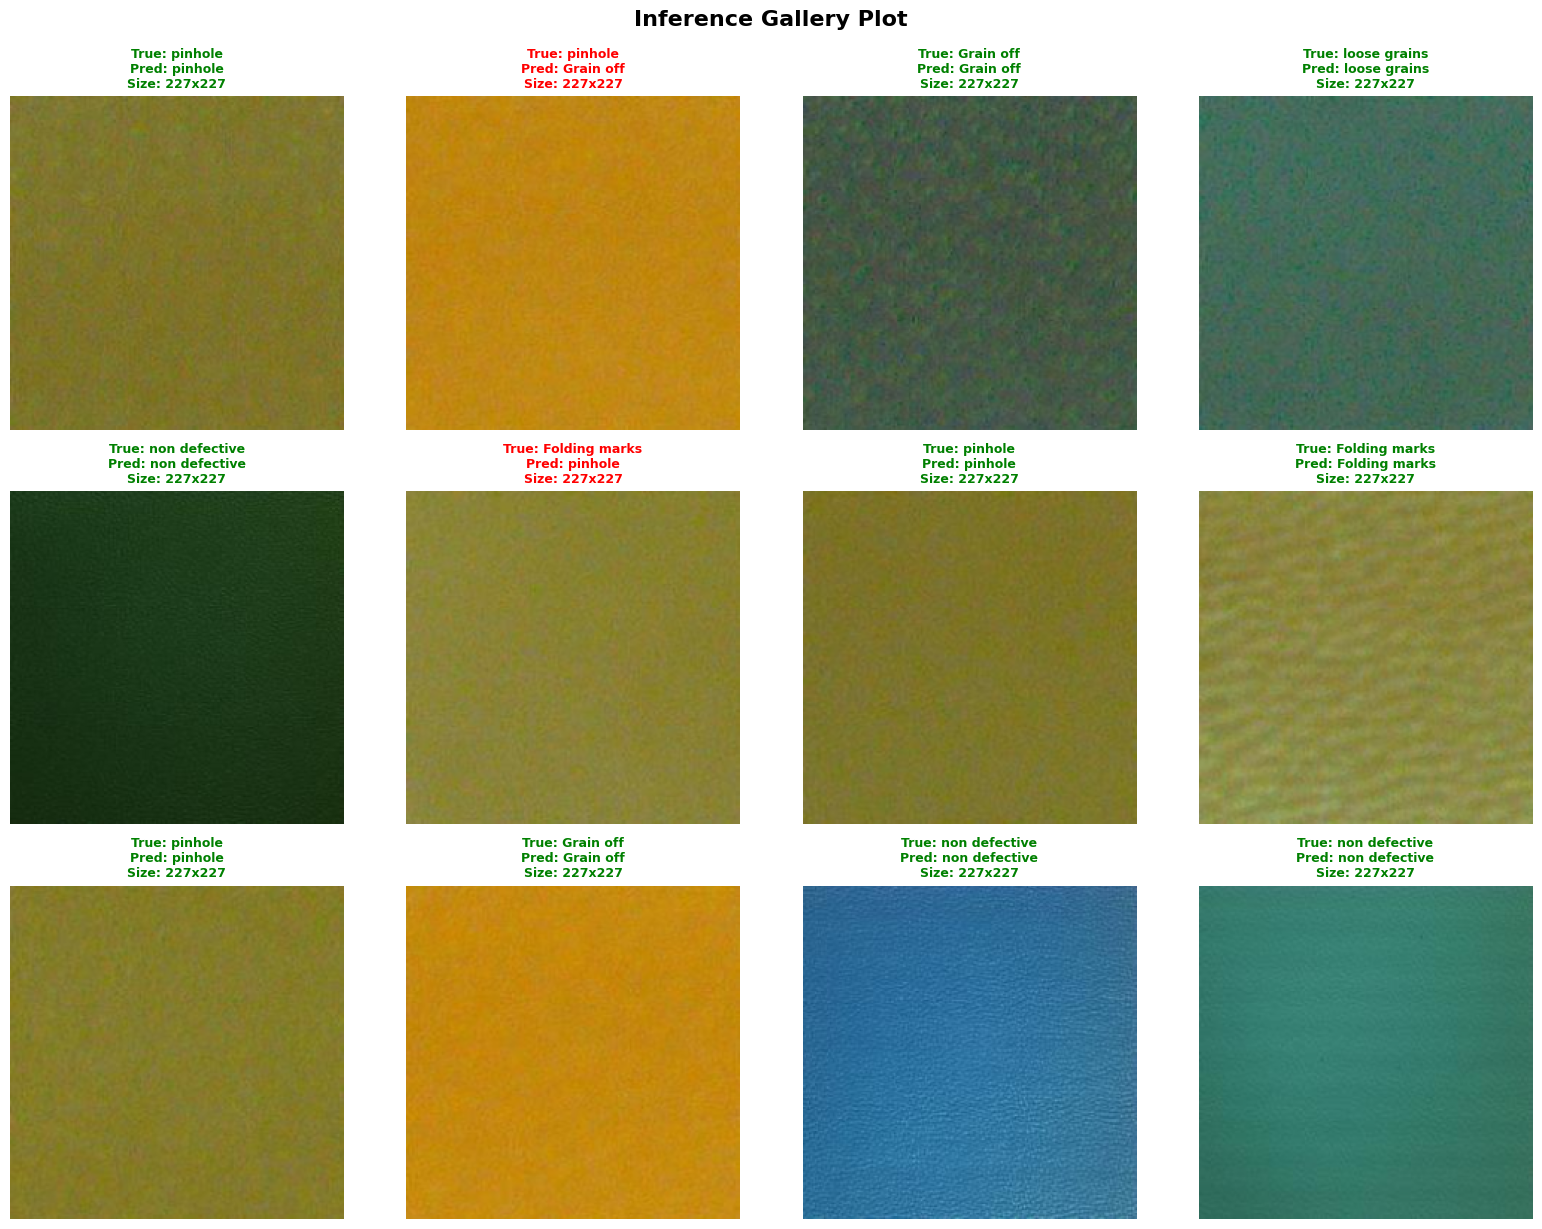

In [ ]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_final_gallery(model, loader, device, classes, num_images=12):
    model.eval()

    plt.figure(figsize=(16, 12))

    dataset = loader.dataset
    indices = random.sample(range(len(dataset)), num_images)

    display_list = []
    with torch.no_grad():
        for idx in indices:
            image, label = dataset[idx]
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            _, pred = torch.max(output, 1)

            display_list.append({
                'image': image,
                'label': label,
                'pred': pred.item()
            })

    for i, item in enumerate(display_list):

        img = item['image'].numpy().transpose((1, 2, 0))

        img = (img * 0.5) + 0.5
        img = np.clip(img, 0, 1)

        plt.subplot(3, 4, i+1)
        plt.imshow(img)

        is_correct = item['pred'] == item['label']
        color = 'green' if is_correct else 'red'

        title = f"True: {classes[item['label']]}\nPred: {classes[item['pred']]}

        plt.title(title, color=color, fontsize=9, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Inference Gallery",
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Final execution
plot_final_gallery(model, val_loader, device, class_names)